
# 04_visualization_dashboard.ipynb
**Omnichannel FMCG — Power BI–Style Dashboard (Notebook Edition)**  
Author: **Derrick Wong**

This notebook mimics a Power BI layout inside Jupyter:
- KPI cards (Revenue, Orders, AOV, Repeat Rate)
- Channel trend (weekly)
- Territory leaderboard
- Category contribution (Pareto)
- Promo vs Non‑Promo uplift
- Simple filters: Date range, Channel, Territory

> Try setting filters in **Section 1**, then **run the cell**.
Charts are saved to `reports/img/` for easy copy‑paste into slides.


## 1) Setup & Filters

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path

# --- Paths (lock to your machine for stability) ---
BASE_DIR = Path(r"C:\Users\inchr\Downloads\Capstone Associate Data Analyst\omnichannel-growth-engine")
CLEAN_PATH = BASE_DIR / "clean" / "cleaned_fmcg_omnichannel_sales.csv"
IMG_DIR = BASE_DIR / "reports" / "img"
IMG_DIR.mkdir(parents=True, exist_ok=True)

# --- Read data ---
# Try parse common date headers automatically
hdr = pd.read_csv(CLEAN_PATH, nrows=0).columns.tolist()
date_cols = [c for c in ["Date","Week_Start","Order_Date","Week"] if c in hdr]
parse_dates = date_cols if date_cols else None
df = pd.read_csv(CLEAN_PATH, parse_dates=parse_dates, low_memory=False)

# --- Canonicalize column names ---
def first_present(cols, candidates):
    for c in candidates:
        if c in cols:
            return c
    return None

col_date     = first_present(df.columns, ["Date","Week_Start","Order_Date","Week"])
col_channel  = first_present(df.columns, ["Channel","channel"])
col_terr     = first_present(df.columns, ["Territory","Region","Area"])
col_cat      = first_present(df.columns, ["Category","Product_Category","SKU_Category"])
col_rev      = first_present(df.columns, ["Revenue","Sales","Net_Sales"])
col_units    = first_present(df.columns, ["Units","Quantity","Qty"])
col_order    = first_present(df.columns, ["Order_ID","OrderId","Txn_ID"])
col_customer = first_present(df.columns, ["Customer_ID","CustomerId","Cust_ID"])
col_promo    = first_present(df.columns, ["Promo_Flag","Promotion_Flag","Promo","Is_Promo"])

# Safety coercions
if col_date:   df[col_date] = pd.to_datetime(df[col_date], errors="coerce")
if col_rev:    df[col_rev]  = pd.to_numeric(df[col_rev], errors="coerce").fillna(0)
if col_units:  df[col_units]= pd.to_numeric(df[col_units], errors="coerce").fillna(0)
if col_promo is None:
    df["__Promo"] = 0
    col_promo = "__Promo"
else:
    df[col_promo] = pd.to_numeric(df[col_promo], errors="coerce").fillna(0).astype(int)

# --- FILTERS (edit these) ---
# Date filter: put yyyy-mm-dd or leave None
DATE_START = None   # e.g., "2025-05-01"
DATE_END   = None   # e.g., "2025-10-31"

# Channel filter: set to list like ["Retail","Shopee"] or None for all
FILTER_CHANNELS = None

# Territory filter: set to list like ["East","West"] or None for all
FILTER_TERRITORIES = None

# --- Apply filters ---
f = df.copy()
if col_date and (DATE_START or DATE_END):
    if DATE_START:
        f = f[f[col_date] >= pd.to_datetime(DATE_START)]
    if DATE_END:
        f = f[f[col_date] <= pd.to_datetime(DATE_END)]

if FILTER_CHANNELS and col_channel:
    f = f[f[col_channel].isin(FILTER_CHANNELS)]

if FILTER_TERRITORIES and col_terr:
    f = f[f[col_terr].isin(FILTER_TERRITORIES)]

print("✅ Data loaded & filtered. Shape:", f.shape)
print("Columns in use:", dict(date=col_date, channel=col_channel, territory=col_terr, category=col_cat, revenue=col_rev, units=col_units, order=col_order, customer=col_customer, promo=col_promo))

# Keep for subsequent sections
df_f = f


✅ Data loaded & filtered. Shape: (122280, 12)
Columns in use: {'date': 'Week_Start', 'channel': 'Channel', 'territory': 'Territory', 'category': 'Category', 'revenue': 'Revenue', 'units': 'Units', 'order': 'Order_ID', 'customer': 'Customer_ID', 'promo': 'Promo_Flag'}


## 2) KPI Cards (like Power BI cards)

In [2]:

def safe_nunique(s):
    try:
        return s.nunique()
    except Exception:
        return np.nan

total_rev = df_f[col_rev].sum() if col_rev else np.nan
orders    = safe_nunique(df_f[col_order]) if col_order else np.nan
customers = safe_nunique(df_f[col_customer]) if col_customer else np.nan
aov       = (total_rev / orders) if (orders and orders>0) else np.nan

repeat_rate = np.nan
if col_customer and col_order:
    cust_orders = df_f.groupby(col_customer)[col_order].nunique()
    repeat_rate = (cust_orders > 1).mean() * 100 if len(cust_orders)>0 else np.nan

kpis = {
    "Total Revenue": f"${total_rev:,.0f}" if pd.notnull(total_rev) else "n/a",
    "Orders": f"{orders:,.0f}" if pd.notnull(orders) else "n/a",
    "AOV": f"${aov:,.2f}" if pd.notnull(aov) else "n/a",
    "Repeat Rate": f"{repeat_rate:.1f}%" if pd.notnull(repeat_rate) else "n/a"
}

print("KPI Cards")
for k,v in kpis.items():
    print(f"- {k}: {v}")


KPI Cards
- Total Revenue: $1,081,786
- Orders: 122,279
- AOV: $8.85
- Repeat Rate: 100.0%


## 3) Channel Sales Trend (weekly)

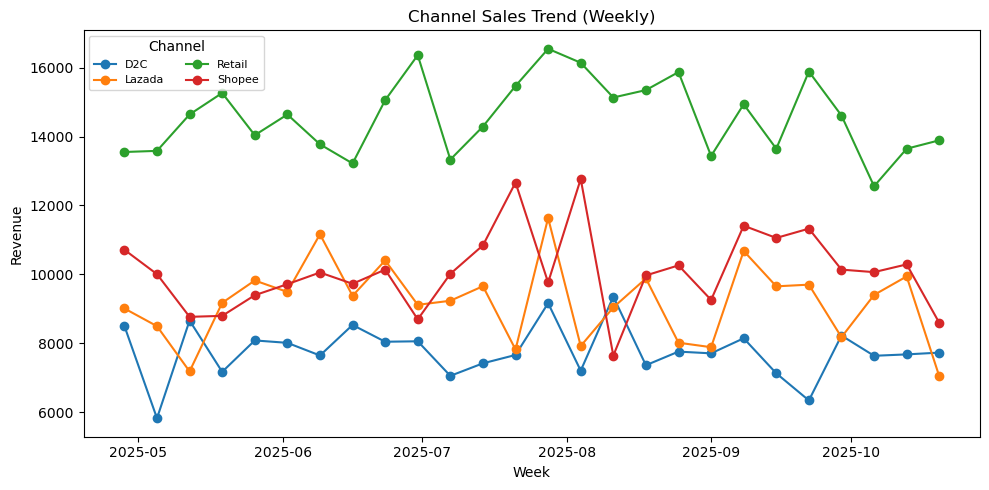

Saved: C:\Users\inchr\Downloads\Capstone Associate Data Analyst\omnichannel-growth-engine\reports\img\01_channel_trend.png


In [3]:

plt.figure(figsize=(10,5))

if col_date and col_channel and col_rev:
    g = df_f.copy()
    g["Week"] = g[col_date].dt.to_period("W").apply(lambda r: r.start_time)
    ts = g.groupby(["Week", col_channel])[col_rev].sum().reset_index()

    # Pivot & plot manually (no seaborn)
    pivot_ts = ts.pivot(index="Week", columns=col_channel, values=col_rev).fillna(0).sort_index()
    for ch in pivot_ts.columns:
        plt.plot(pivot_ts.index, pivot_ts[ch], marker="o", linewidth=1.5, label=ch)

    plt.title("Channel Sales Trend (Weekly)")
    plt.xlabel("Week"); plt.ylabel("Revenue")
    plt.legend(title="Channel", ncol=2, fontsize=8)
    plt.tight_layout()
    out = IMG_DIR / "01_channel_trend.png"
    plt.savefig(out, dpi=160, bbox_inches="tight")
    plt.show()
    print("Saved:", out)
else:
    print("Missing required columns for trend chart.")


## 4) Territory Leaderboard

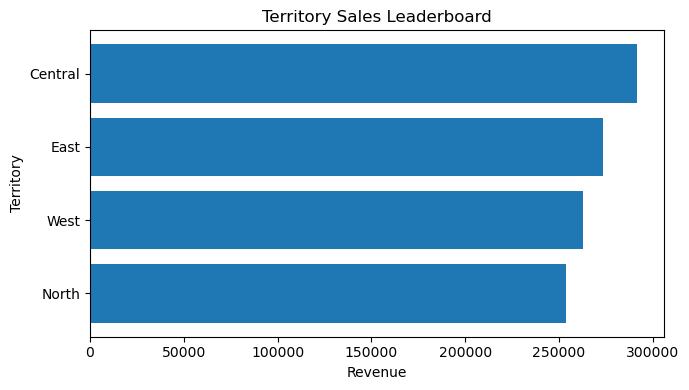

Saved: C:\Users\inchr\Downloads\Capstone Associate Data Analyst\omnichannel-growth-engine\reports\img\02_territory_leaderboard.png


In [4]:

plt.figure(figsize=(7,4))

if col_terr and col_rev:
    terr = df_f.groupby(col_terr)[col_rev].sum().sort_values(ascending=False)
    y = terr.index.tolist()[::-1]
    x = terr.values.tolist()[::-1]
    plt.barh(y, x)
    plt.title("Territory Sales Leaderboard")
    plt.xlabel("Revenue"); plt.ylabel("Territory")
    plt.tight_layout()
    out = IMG_DIR / "02_territory_leaderboard.png"
    plt.savefig(out, dpi=160, bbox_inches="tight")
    plt.show()
    print("Saved:", out)
else:
    print("Missing Territory/Revenue columns.")


## 5) Category Contribution (Pareto 80/20 style)

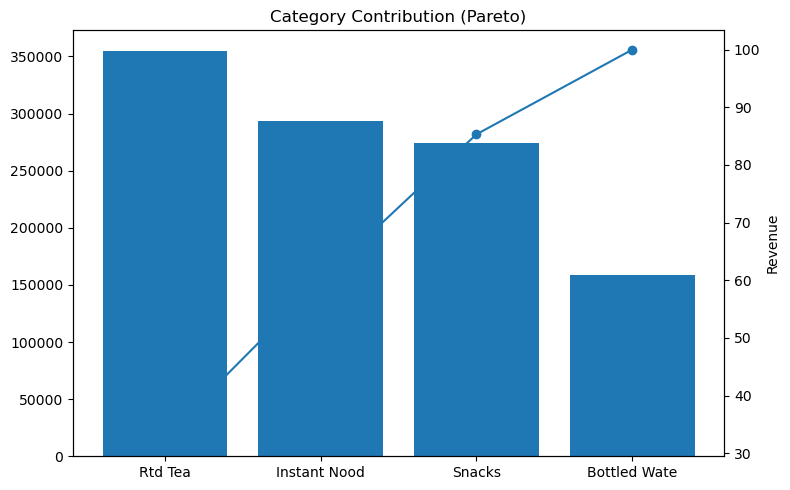

Saved: C:\Users\inchr\Downloads\Capstone Associate Data Analyst\omnichannel-growth-engine\reports\img\03_category_pareto.png


In [5]:

plt.figure(figsize=(8,5))

if col_cat and col_rev:
    cat = df_f.groupby(col_cat)[col_rev].sum().sort_values(ascending=False)
    cum = (cat.cumsum() / cat.sum()) * 100

    # Bar
    plt.bar(range(len(cat)), cat.values)
    # Cumulative line (second axis)
    ax2 = plt.twinx()
    ax2.plot(range(len(cum)), cum.values, marker="o", linewidth=1.5)
    ax2.set_ylabel("Cumulative %")

    plt.title("Category Contribution (Pareto)")
    plt.xlabel("Category (ranked)"); plt.ylabel("Revenue")
    plt.xticks(range(len(cat)), [str(c)[:12] for c in cat.index], rotation=45, ha="right")
    plt.tight_layout()
    out = IMG_DIR / "03_category_pareto.png"
    plt.savefig(out, dpi=160, bbox_inches="tight")
    plt.show()
    print("Saved:", out)
else:
    print("Missing Category/Revenue columns.")


## 6) Promo vs Non‑Promo Uplift (Avg revenue per order)

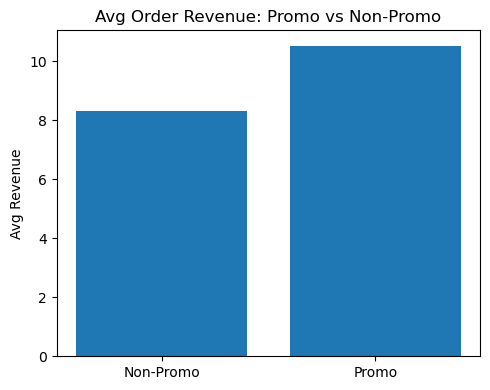

Saved: C:\Users\inchr\Downloads\Capstone Associate Data Analyst\omnichannel-growth-engine\reports\img\04_promo_uplift.png
📈 Promo uplift vs Non‑Promo: 26.7%


In [6]:

plt.figure(figsize=(5,4))

if col_order and col_promo and col_rev:
    ordrev = df_f.groupby([col_order, col_promo])[col_rev].sum().reset_index()
    avg = ordrev.groupby(col_promo)[col_rev].mean()
    labels = ["Non‑Promo" if int(i)==0 else "Promo" for i in avg.index]

    plt.bar(labels, avg.values)
    plt.title("Avg Order Revenue: Promo vs Non‑Promo")
    plt.ylabel("Avg Revenue")
    plt.tight_layout()
    out = IMG_DIR / "04_promo_uplift.png"
    plt.savefig(out, dpi=160, bbox_inches="tight")
    plt.show()
    print("Saved:", out)

    if 0 in avg.index and 1 in avg.index and avg[0] > 0:
        uplift = (avg[1]/avg[0]-1)*100
        print(f"📈 Promo uplift vs Non‑Promo: {uplift:.1f}%")
else:
    print("Missing Order/Promo/Revenue columns.")


## 7) Repeat Purchase Frequency

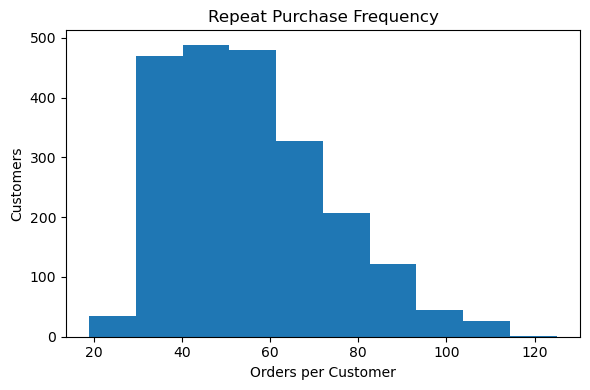

Saved: C:\Users\inchr\Downloads\Capstone Associate Data Analyst\omnichannel-growth-engine\reports\img\05_repeat_purchase.png
🔁 % repeat buyers: 100.0%
📊 Avg orders per customer: 55.58


In [7]:

plt.figure(figsize=(6,4))

if col_customer and col_order:
    cust_orders = df_f.groupby(col_customer)[col_order].nunique()
    plt.hist(cust_orders.values, bins=10)
    plt.title("Repeat Purchase Frequency")
    plt.xlabel("Orders per Customer"); plt.ylabel("Customers")
    plt.tight_layout()
    out = IMG_DIR / "05_repeat_purchase.png"
    plt.savefig(out, dpi=160, bbox_inches="tight")
    plt.show()
    print("Saved:", out)

    print(f"🔁 % repeat buyers: {(cust_orders>1).mean()*100:.1f}%")
    print(f"📊 Avg orders per customer: {cust_orders.mean():.2f}")
else:
    print("Missing Customer_ID/Order_ID columns.")


## 8) Summary Panel (copy into slides)

In [8]:

summary = []

# Top Territory & Channel
if col_terr and col_rev:
    terr_sum = df_f.groupby(col_terr)[col_rev].sum()
    if not terr_sum.empty:
        summary.append(f"🏁 Top Territory: {terr_sum.idxmax()} (S${terr_sum.max():,.0f})")

if col_channel and col_rev:
    ch_sum = df_f.groupby(col_channel)[col_rev].sum()
    if not ch_sum.empty:
        summary.append(f"🏆 Top Channel: {ch_sum.idxmax()} (S${ch_sum.max():,.0f})")

# Promo uplift
if col_order and col_promo and col_rev:
    ordrev = df_f.groupby([col_order, col_promo])[col_rev].sum().reset_index()
    avg = ordrev.groupby(col_promo)[col_rev].mean()
    if 0 in avg.index and 1 in avg.index and avg[0] > 0:
        uplift = (avg[1]/avg[0]-1)*100
        summary.append(f"📈 Promo Uplift: {uplift:.1f}% (Avg order revenue)")

# Repeat rate
if col_customer and col_order:
    cust_orders = df_f.groupby(col_customer)[col_order].nunique()
    repeat_rate = (cust_orders>1).mean()*100 if len(cust_orders)>0 else np.nan
    summary.append(f"🔁 Repeat Buyer Rate: {repeat_rate:.1f}%")

print("\\n".join(summary) if summary else "No summary available — check filters/columns.")


🏁 Top Territory: Central (S$291,666)\n🏆 Top Channel: Retail (S$378,879)\n📈 Promo Uplift: 26.7% (Avg order revenue)\n🔁 Repeat Buyer Rate: 100.0%
